In [60]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, mean_squared_error


In [2]:
file_path = '../RiceDatathon/OilData.csv'
data = pd.read_csv(file_path)


In [3]:

data_cleaned = data.dropna(subset=['OilPeakRate']) # 
data_unnamed = data_cleaned.copy()
data_unnamed = data_unnamed.drop(columns="Unnamed: 0")
data_with_oilpeak = data_unnamed.dropna(subset=['OilPeakRate']).copy()
data_without_oilpeak = data_unnamed[data_unnamed['OilPeakRate'].isnull()].copy()


for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype == 'object':
            mode_value = data[column].mode()[0]
            data_with_oilpeak.loc[:, column] = data_with_oilpeak[column].fillna(mode_value)
            data_without_oilpeak.loc[:, column] = data_without_oilpeak[column].fillna(mode_value)
        else:
            median_value = data[column].median()
            data_with_oilpeak.loc[:, column] = data_with_oilpeak[column].fillna(median_value)
            data_without_oilpeak.loc[:, column] = data_without_oilpeak[column].fillna(median_value)


threshold = 50  # percentage
missing_values_percentage = (data_with_oilpeak.isnull().sum() / len(data_with_oilpeak)) * 100
columns_to_drop = missing_values_percentage[missing_values_percentage > threshold].index
data_with_oilpeak_reduced = data_with_oilpeak.drop(columns=columns_to_drop)

remaining_missing_with_oilpeak = data_with_oilpeak_reduced.isnull().sum().sum()
# remaining_missing_without_oilpeak = data_without_oilpeak.isnull().sum().sum()
print("Missing values in dataset with OilPeakRate:", remaining_missing_with_oilpeak)
# print("Missing values in dataset without OilPeakRate:", remaining_missing_without_oilpeak)


target_data = data_with_oilpeak_reduced[['OilPeakRate']].copy()
data_with_oilpeak_reduced = data_with_oilpeak_reduced.drop(columns=['OilPeakRate'])
# data_with_oilpeak_reduced.info()
print(target_data.shape)
print(data_with_oilpeak_reduced.shape)
# data_without_oilpeak.info()





Missing values in dataset with OilPeakRate: 0
(19306, 1)
(19306, 29)


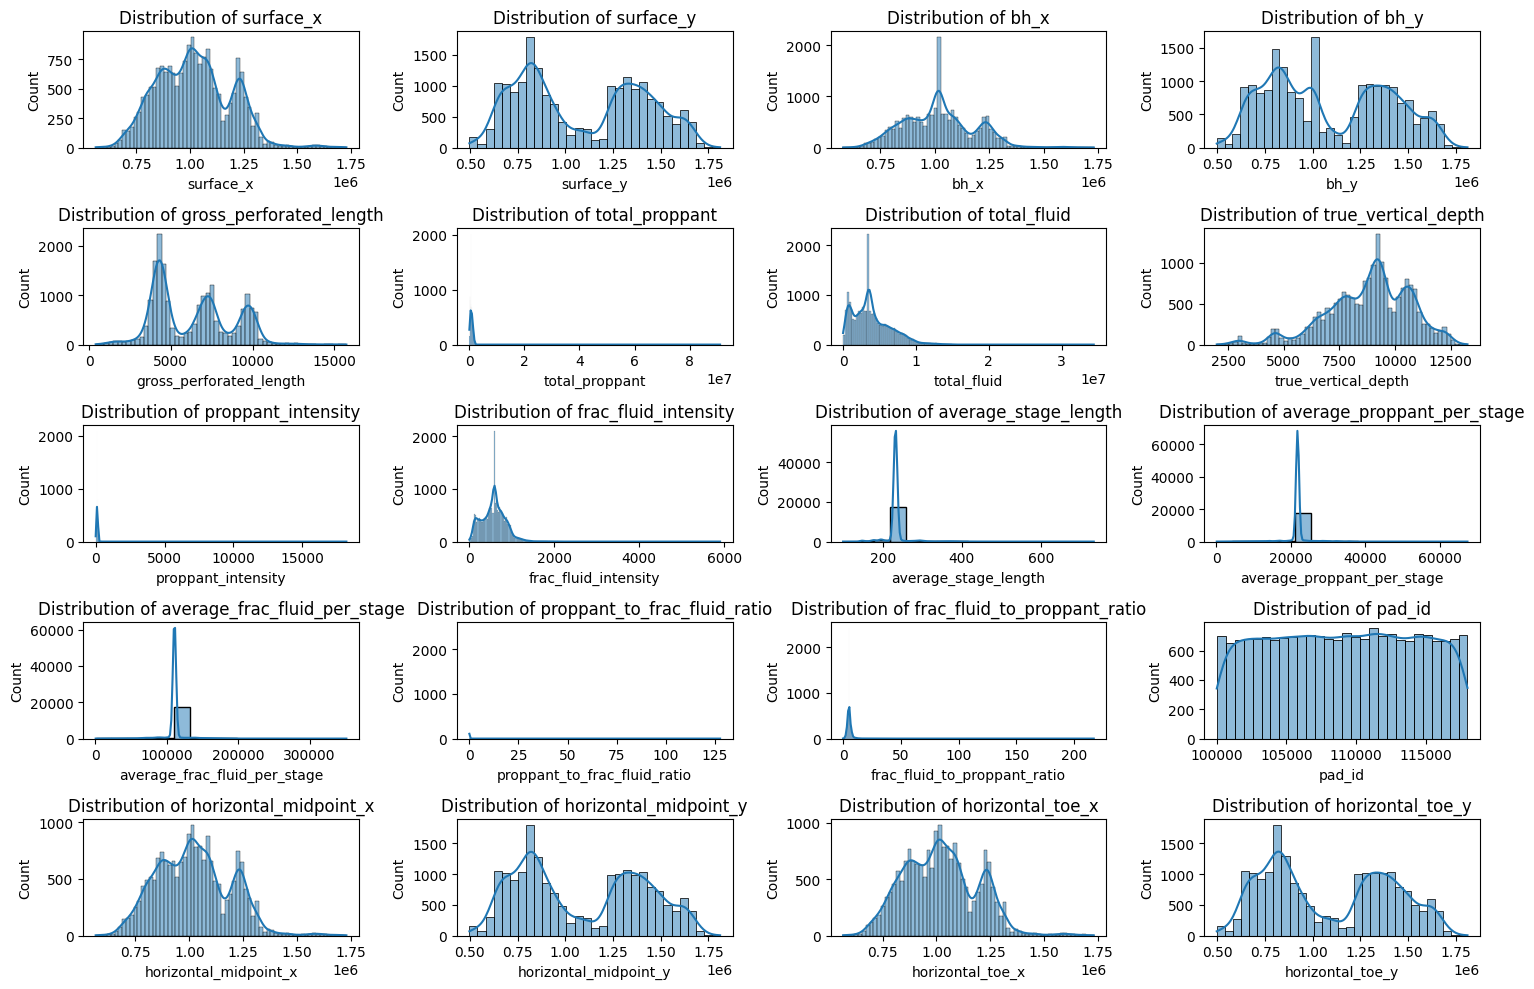

In [4]:
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','average_stage_length',
                     'average_proppant_per_stage','average_frac_fluid_per_stage','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y'] 

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data_with_oilpeak_reduced[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

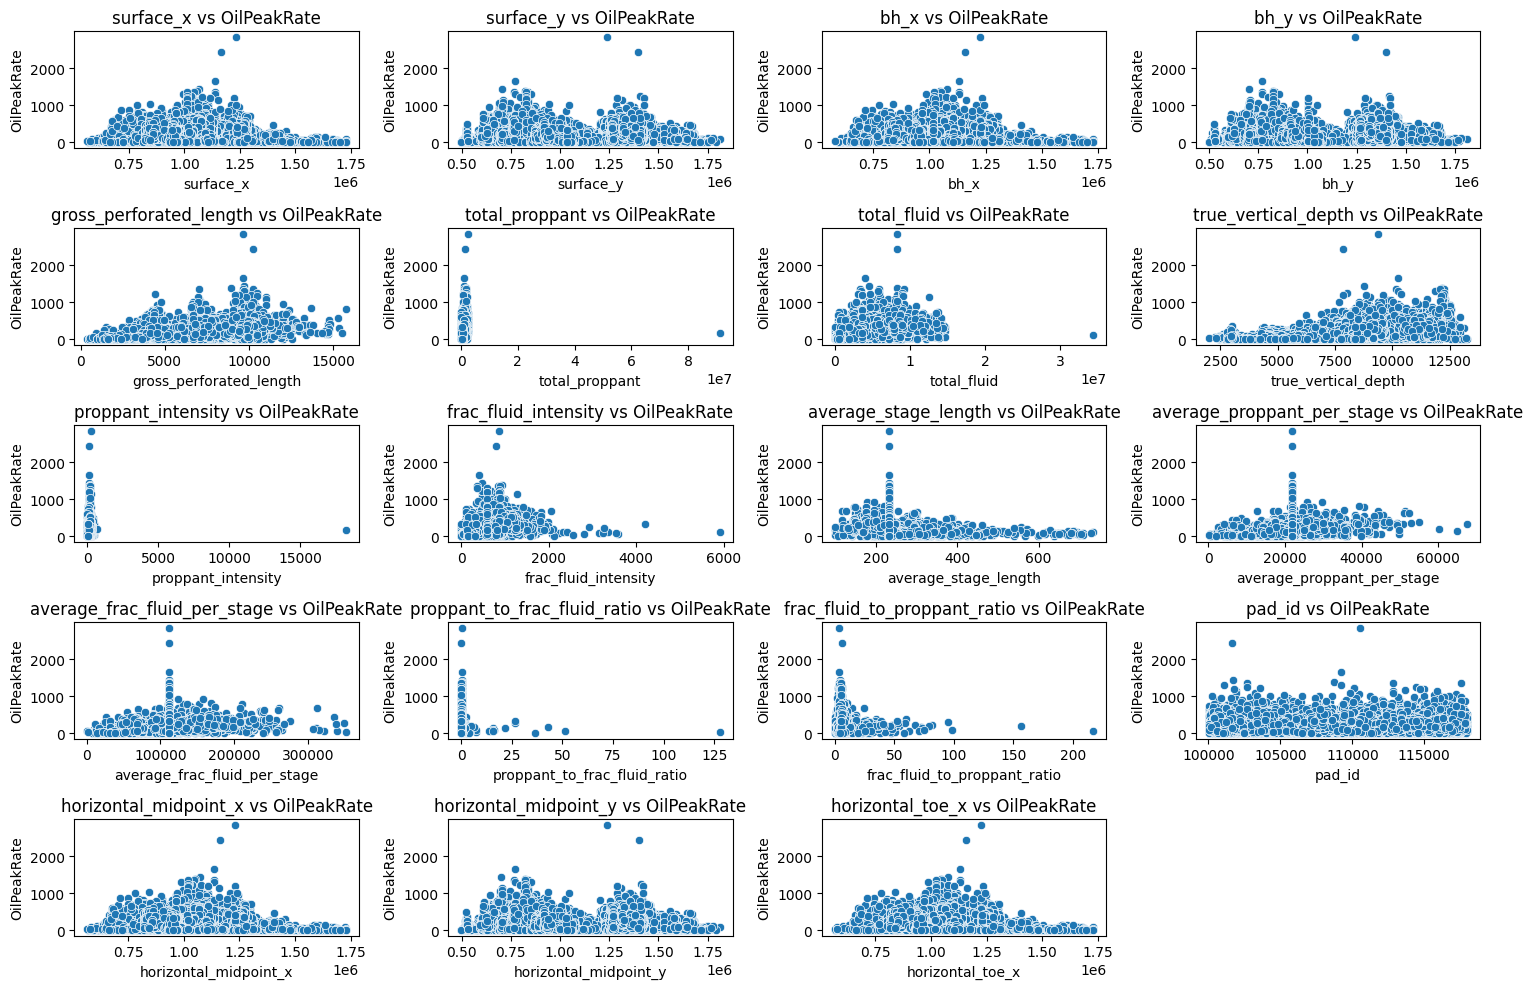

In [5]:
target_variable = 'OilPeakRate' 
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns[:-1], 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=data_with_oilpeak_reduced[column], y=target_data[target_variable])
    plt.title(f'{column} vs {target_variable}')
plt.tight_layout()
plt.show()

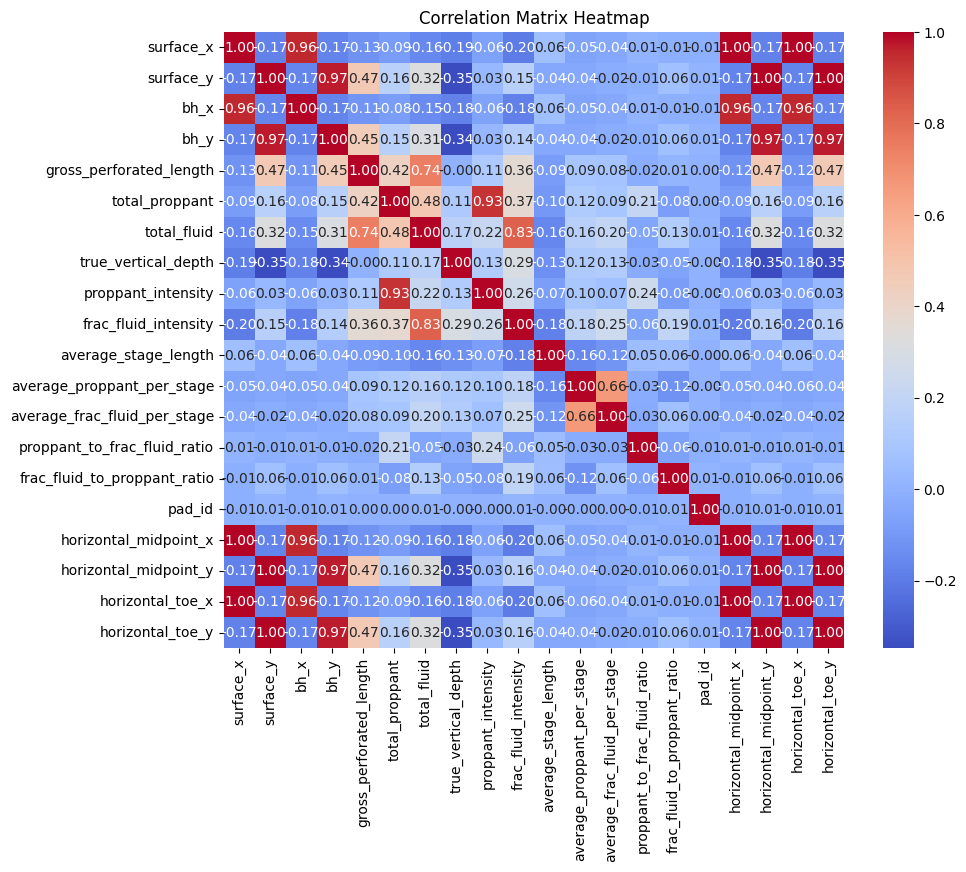

In [6]:
corr_matrix = data_with_oilpeak_reduced[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
surface_coordinates = data_with_oilpeak_reduced[['surface_x', 'surface_y']]
kmeans_surface = KMeans(n_clusters=5)
surface_clusters = kmeans_surface.fit_predict(surface_coordinates)
data_with_oilpeak_reduced['surface_cluster'] = surface_clusters

bh_coordinates = data_with_oilpeak_reduced[['bh_x', 'bh_y']]
kmeans_bh = KMeans(n_clusters=5)
bh_clusters = kmeans_bh.fit_predict(bh_coordinates)
data_with_oilpeak_reduced['bh_cluster'] = bh_clusters

mid_coordinates = data_with_oilpeak_reduced[['horizontal_midpoint_x', 'horizontal_midpoint_y']]
kmeans_mid = KMeans(n_clusters=5)
mid_clusters = kmeans_mid.fit_predict(mid_coordinates)
data_with_oilpeak_reduced['mid_clusters'] = mid_clusters

toe_coordinates = data_with_oilpeak_reduced[['horizontal_toe_x', 'horizontal_toe_y']]
kmeans_toe = KMeans(n_clusters=5)
toe_clusters = kmeans_toe.fit_predict(toe_coordinates)
data_with_oilpeak_reduced['toe_clusters'] = toe_clusters

data_with_oilpeak_reduced.head()


c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,surface_cluster,bh_cluster,mid_clusters,toe_clusters
0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,27.0,76000.0000,3.564951e+06,8712.598425,...,Primary Frac,38.0,1383030.678,714796.3610,1382668.912,712798.4321,3,4,4,4
1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,27.0,113000.0000,5.610964e+05,8627.952756,...,Primary Frac,38.0,1379965.126,709541.7145,1379630.025,707907.6708,3,4,4,4
2,1379915.895,717845.0063,1379274.644,713471.9952,1304,3810.039370,12.0,286571.4286,1.621424e+06,8801.181102,...,Primary Frac,92.0,1379357.250,715381.2327,1378960.372,713530.4490,3,4,4,4
3,1383567.443,706640.2010,1382891.477,702068.3838,1022,3723.425197,11.0,106878.9286,4.377134e+05,8635.826772,...,Primary Frac,38.0,1383099.610,704058.8508,1382727.299,702098.4882,3,4,4,4
4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,27.0,112789.7143,6.229802e+05,8664.370079,...,Primary Frac,38.0,1379546.414,705150.7519,1379987.487,707123.7258,3,4,4,4


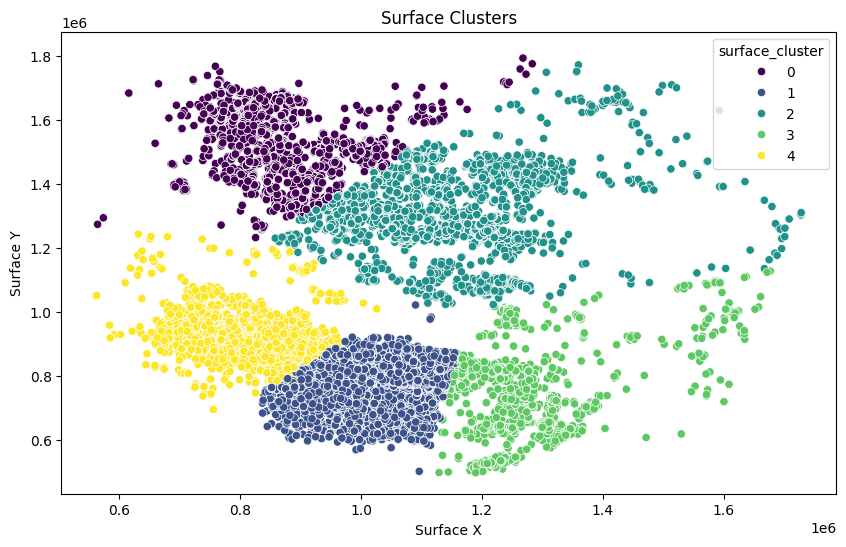

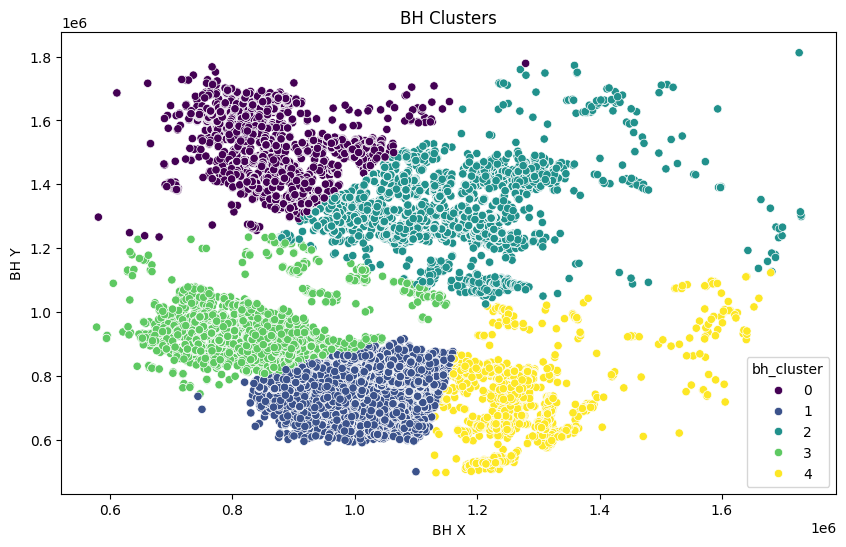

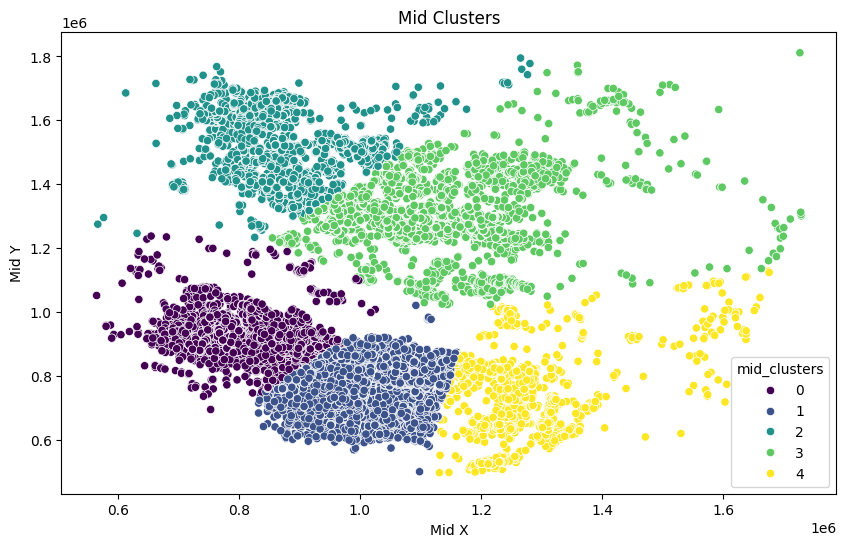

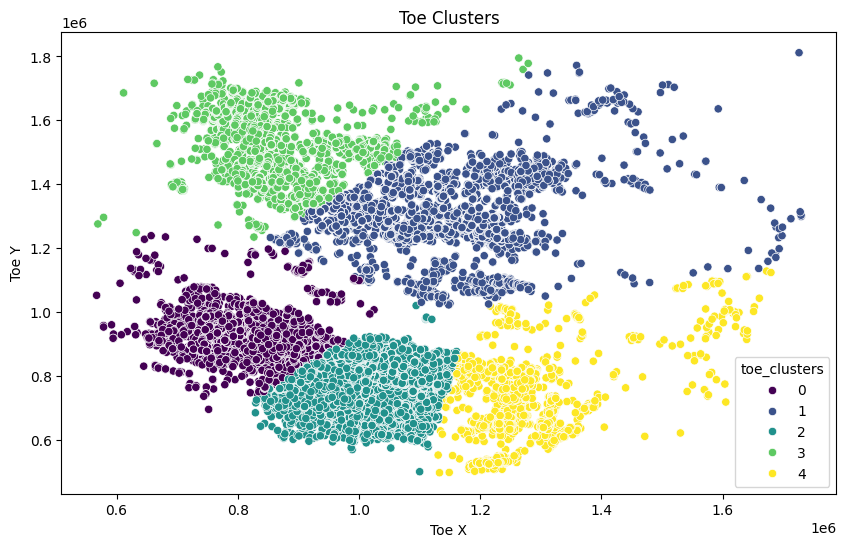

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='surface_x', y='surface_y', hue='surface_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Surface Clusters')
plt.xlabel('Surface X')
plt.ylabel('Surface Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bh_x', y='bh_y', hue='bh_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('BH Clusters')
plt.xlabel('BH X')
plt.ylabel('BH Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_midpoint_x', y='horizontal_midpoint_y', hue='mid_clusters', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Mid Clusters')
plt.xlabel('Mid X')
plt.ylabel('Mid Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_toe_x', y='horizontal_toe_y', hue='toe_clusters', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Toe Clusters')
plt.xlabel('Toe X')
plt.ylabel('Toe Y')
plt.show()

In [10]:
data_with_cluster = data_with_oilpeak_reduced.drop(columns=["bh_x","bh_y","bh_cluster","surface_x","surface_y","mid_clusters",
                                                       "toe_clusters","horizontal_midpoint_x","horizontal_midpoint_y",
                                                       "horizontal_toe_x","horizontal_toe_y"])
data_with_cluster.info()
print(data_with_cluster.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   standardized_operator_name    19306 non-null  int64  
 1   gross_perforated_length       19306 non-null  float64
 2   number_of_stages              19306 non-null  float64
 3   total_proppant                19306 non-null  float64
 4   total_fluid                   19306 non-null  float64
 5   true_vertical_depth           19306 non-null  float64
 6   ffs_frac_type                 19306 non-null  object 
 7   proppant_intensity            19306 non-null  float64
 8   frac_fluid_intensity          19306 non-null  float64
 9   average_stage_length          19306 non-null  float64
 10  average_proppant_per_stage    19306 non-null  float64
 11  average_frac_fluid_per_stage  19306 non-null  float64
 12  proppant_to_frac_fluid_ratio  19306 non-null  float64
 13  frac_f

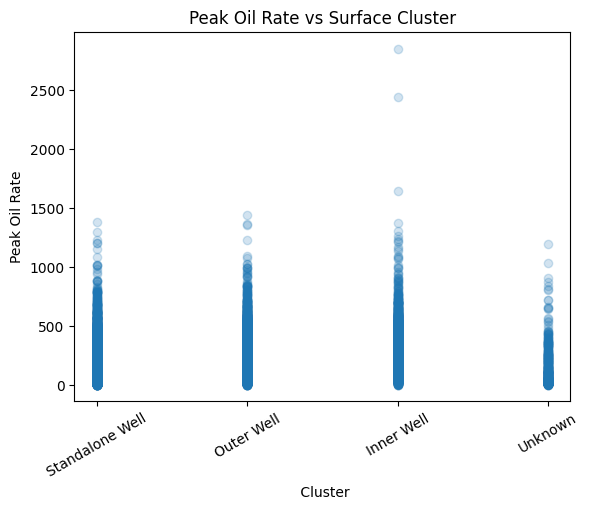

In [12]:
x = data_with_cluster['relative_well_position']
y = target_data[target_variable]

plt.plot(x, y, 'o', alpha=0.2) 
plt.xlabel(' Cluster')
plt.ylabel('Peak Oil Rate')
plt.title('Peak Oil Rate vs Surface Cluster')
plt.xticks(rotation=30)
plt.show()

In [169]:
# data_with_cluster.to_csv('dataclust.csv', index=False)

In [15]:
# data_with_cluster.info()
target_data.info()
target_data.head()
# target_data.to_csv('targ.csv', index=False)

# combined_data = pd.concat([data_with_cluster, target_data], axis=1)
# combined_data.head()


<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OilPeakRate  19306 non-null  float64
dtypes: float64(1)
memory usage: 301.7 KB


,OilPeakRate
0,46.623023
1,59.750009
2,10.785716
3,123.797638
4,102.309540


In [37]:
categorical_cols = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship', 'frac_type']

for col in categorical_cols:
    le = LabelEncoder()
    data_with_cluster[col] = le.fit_transform(data_with_cluster[col])

Y = target_data['OilPeakRate']
X = data_with_cluster

infinite_cols = X.columns.to_series()[np.isinf(X).any()]

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = X.fillna(X.median())

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:            OilPeakRate   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     476.0
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:28:57   Log-Likelihood:            -1.2083e+05
No. Observations:               19306   AIC:                         2.417e+05
Df Residuals:                   19284   BIC:                         2.419e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [38]:
def forward_selection(X, Y, significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(Y, sm.add_constant(X[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

selected_features = forward_selection(X, Y)
print("Selected features:", selected_features)

X_selected = sm.add_constant(X[selected_features])
model = sm.OLS(Y, X_selected).fit()
print(model.summary())

Selected features: ['bin_lateral_length', 'true_vertical_depth', 'const', 'total_fluid', 'relative_well_position', 'frac_fluid_to_proppant_ratio', 'frac_seasoning', 'total_proppant', 'batch_frac_classification', 'standardized_operator_name', 'proppant_intensity', 'frac_fluid_intensity', 'number_of_stages', 'average_stage_length', 'gross_perforated_length', 'surface_cluster', 'well_family_relationship', 'average_proppant_per_stage', 'average_frac_fluid_per_stage']
                            OLS Regression Results                            
Dep. Variable:            OilPeakRate   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     555.0
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:29:09   Log-Likelihood:            -1.2083e+05
No. Observations:               19306   AIC:              

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=0)

random_forest_model = RandomForestRegressor(random_state=0)

# param_dist = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }
# random_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_dist, 
#                                    n_iter=10, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=0, cv=5)
# random_search.fit(X_train, y_train)

# Best parameters
# best_params = random_search.best_params_
best_params = param_dist = {
    'n_estimators': 20,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

rf_best = RandomForestRegressor(**best_params, random_state=0)
rf_best.fit(X_train, y_train)

y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("CV RMSE Scores:", -cv_scores)

bagging_model = BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=50, random_state=0)
bagging_model.fit(X_train, y_train)
bagging_train_rmse = np.sqrt(mean_squared_error(y_train, bagging_model.predict(X_train)))
bagging_test_rmse = np.sqrt(mean_squared_error(y_test, bagging_model.predict(X_test)))
print("Bagging - Training RMSE:", bagging_train_rmse)
print("Bagging - Testing RMSE:", bagging_test_rmse)

Training RMSE: 101.70012379557117
Testing RMSE: 101.9753742160885
CV RMSE Scores: [110.22498129 114.45484268 115.74931932 108.27689398 105.92352866]


c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging - Training RMSE: 62.82627774065774
Bagging - Testing RMSE: 93.34427691613068


In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'], 
    'kernel': ['rbf', 'linear']
}
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_

final_svr_model = SVR(**best_params)
final_svr_model.fit(X_train_scaled, y_train)

y_train_pred = final_svr_model.predict(X_train_scaled)
y_test_pred = final_svr_model.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

Training RMSE: 118.68253818494375
Testing RMSE: 110.71905141094975
